In [1]:
import os
import math
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
x = [1,2,3,4,5]
y = ['a','b','c','d','e']
seed = 19
x = shuffle(x, random_state=seed)
y = shuffle(y, random_state=seed)
print(x)
print(y)

[2, 5, 4, 1, 3]
['b', 'e', 'd', 'a', 'c']


In [31]:
import numpy as np
root_path = os.getcwd()


class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, X : np.array, Y : np.array, batch_size : int = 8,input_size : int = 128,
                 shuffle : bool =True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.IMG_SIZE = input_size
        self.shuffle = shuffle
        self.data_aug = True
    
    
    def __len__(self):
        return int(len(self.X)/ self.batch_size)

    def __img_preprocess(self,image_path):
        img = cv2.imread(image_path)
        if img is None : 
            return None
            
        image = tf.cast(img, tf.float32)
        image = tf.image.resize(image, [self.IMG_SIZE, self.IMG_SIZE])
        image = (image / 255.0)
        image = tf.image.random_brightness(image, max_delta=0.5)

        if self.data_aug:
            augmented_image = self.data_augmentation(image=image)
            return image
        else:

            return image


    def data_augmentation(self,image):
        data_augmentation = tf.keras.Sequential([
                        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                        tf.keras.layers.RandomRotation(0.2)])
        augmented_image =  data_augmentation(image)
        return augmented_image



    
    def __get_data(self,x_batches, y_batches):
         # Generates data containing batch_size samples
        X_batchs = []
        Y_batches = []
        for x,y in zip(x_batches,y_batches):
            preprocessed_img =  self.__img_preprocess(x) 
            if preprocessed_img is None:
                continue
            X_batchs.append(preprocessed_img)
            Y_batches.append(y)
            

        X_batchs = np.array(X_batchs)
        Y_batches = np.array(Y_batches)
        
        return X_batchs,Y_batches
    



    def __getitem__(self, idx):
        #print()
        #print('getitem', idx)
        seed = np.random.randint(1,100)
        self.X = shuffle(self.X, random_state=seed)
        self.Y = shuffle(self.Y, random_state=seed)
  

        batch_x = self.X[idx * self.batch_size: (idx+1)* self.batch_size]
        batch_y = self.Y[idx * self.batch_size : (idx+1) * self.batch_size]
        
        cur_X,cur_Y = self.__get_data(batch_x,batch_y)
        return cur_X,cur_Y
        




    def on_epoch_end(self):
        print('on_epoch_end')
        #import sys
        #sys.exit()
        seed = np.random.randint(1,100)
        self.X = shuffle(self.X, random_state=seed)
        self.Y = shuffle(self.Y, random_state=seed)


In [32]:
result_list = np.array([0 for _ in range(4)])
print(result_list)

test_x = ["a","b","c"]
print(test_x.index("a"))

[0 0 0 0]
0


In [33]:
def OneHotEncoder(input_list :list):
    unique_class = set(input_list)
    unique_class = list(unique_class)
    result_list = []
    for temp in input_list:
        # create 0 array
        onehot_arr = np.array([0 for _ in range(len(unique_class))])
        onehot_arr[unique_class.index(temp)] = 1
        result_list.append(onehot_arr)
    return result_list,unique_class

In [34]:
# for mac delete .DS_Store
# find . -name '.DS_Store' -type f -delete



label_encode = {'Melanocytic nevi' : [0,0,1] ,
                'Benign keratosis-like lesions':[0,1,0], 
                'Melanoma' : [1,0,0]}


In [35]:

def load_dataset(dataset_path : str):
    x_test, y_test = [],[]
    encoding_label = []
    for cur_class in  os.listdir(dataset_path):

        temp_path = dataset_path+"/"+cur_class
        for file_name in os.listdir(temp_path):
            img_path = temp_path+"/"+file_name
            x_test.append(img_path)
            encode_label = label_encode[cur_class]
            y_test.append(encode_label)


    print("Encoded label : ",encoding_label)
    y_test = np.array(y_test)
    x_test = np.array(x_test)


    return x_test, y_test





input_size = 128
input_shape = (128,128,3)
output_shape = 3
batch_size = 32


# load test path 
test_path = os.getcwd()+"/skin_cancer/test/"
x_test,y_test = load_dataset(test_path)


#load train path
train_path = os.getcwd()+"/skin_cancer/train/"
x_train,y_train = load_dataset(train_path)








Encoded label :  []
Encoded label :  []


In [36]:
test_gen = CustomDataGen(X=x_test,Y=y_test,batch_size=batch_size,input_size=input_size,shuffle=True)
train_gen = CustomDataGen(X=x_train,Y=y_train,batch_size=batch_size,input_size=input_size,shuffle=True)

Max index : 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11006658..0.80981684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16878228..0.7090816].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04177627..0.77772415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17178546..0.6630809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.038620636..0.8092654].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07820397..0.78948903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

x :  (32, 128, 128, 3)
y :  (32, 3)


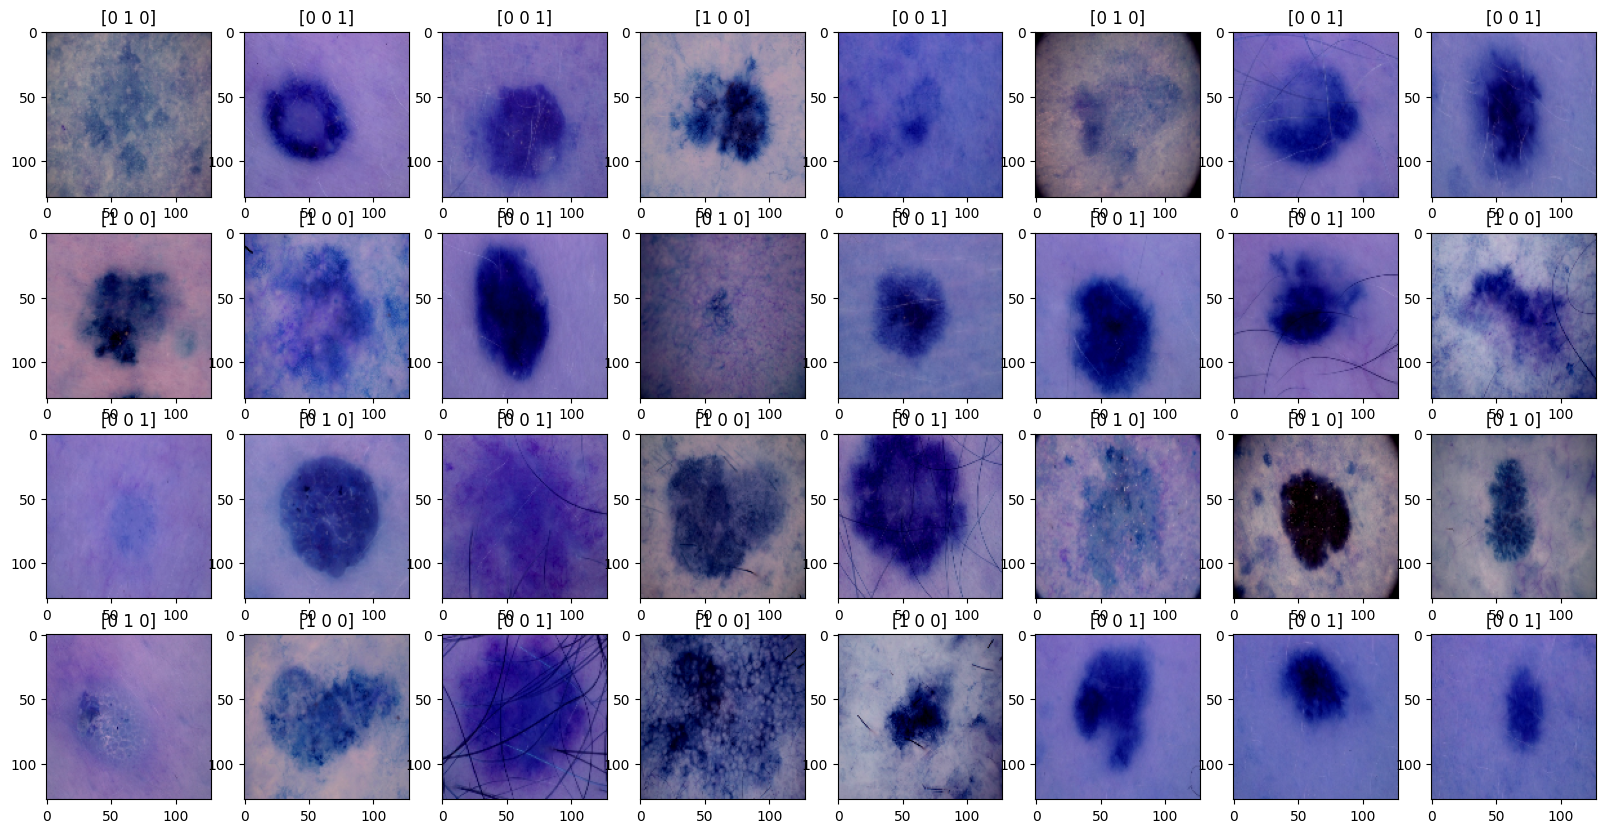

In [37]:
test_idx =5

print("Max index :", test_gen.__len__())
x,y = test_gen.__getitem__(4)

print("x : ",x.shape)
print("y : ",y.shape)

# plot sample
w = 20
h = 25
fig = plt.figure(figsize=(20, 10))
columns = 8  
rows = 4

count_id = 0
for i in range(1, columns*rows +1):
    img = x[count_id]
    cur_label = (y[count_id])


    ax1 = fig.add_subplot(rows, columns, i)
    ax1.set_title(cur_label)
    plt.imshow(img)
    count_id = count_id+1
plt.show()

In [38]:
epochs = 50
base_learning_rate = 1e-3

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

def lr_schedule(epoch,lr):
    # Learning Rate Schedule

    total_epochs = epochs

    check_1 = int(total_epochs * 0.9)
    check_2 = int(total_epochs * 0.8)
    check_3 = int(total_epochs * 0.5)
    check_4 = int(total_epochs * 0.4)

    if epoch > check_1:
        lr *= 1e-5 #0.00001
    elif epoch > check_2:
        lr *= 1e-4 #0.0001
    elif epoch > check_3:
        lr *= 1e-3
    elif epoch > check_4:
        lr *= 1e-2

    print("[+] Current Lr rate : {} ".format(lr))
    return lr




In [39]:
lr_schedule(10,0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

[+] Current Lr rate : 0.1 


In [40]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
# for customer layer save
checkpoint_path = "training_1/custom_model.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



In [42]:
from tensorflow.keras.layers import Dense,MaxPooling2D,Flatten,Conv2D,Dropout,BatchNormalization
from tensorflow.keras.models import Model
import keras

class MyModel(Model):
    def __init__(self,input_shape, output_shape):
        super().__init__()
        self.input_layer = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape= input_shape,kernel_regularizer='l1')
        
        self.conv2d_32 = Conv2D(32, kernel_size=(3,3), activation='relu',)
        self.conv1d_64 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')
        self.conv2d_64 = Conv2D(64, kernel_size=(3,3), activation='relu')
        self.conv2d_128 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
        self.maxPool_2d =  MaxPooling2D(pool_size=(2,2))
        
        self.f1 = Flatten()
        self.d1 = Dense(256, activation='relu',kernel_regularizer='l1')
        self.dropout_1 = Dropout(0.3)
        self.d2 = Dense(256, activation='relu')
        self.dropout_2 = Dropout(0.3)
        self.d3 = Dense(128, activation='relu')

        

        self.output_layer = Dense(output_shape, activation="sigmoid")
    
    def call(self, x):
        x = self.input_layer(x)
        x = self.conv2d_32(x)
        x = self.maxPool_2d(x)
        x = self.conv1d_64(x)
        x = self.conv2d_64(x)
        x = self.maxPool_2d(x)
        x = self.conv2d_128(x)
        x = self.f1(x)
        x = self.d1(x)
        x = self.dropout_1(x)
        x = self.d2(x)
        x = self.dropout_2(x)
        x = self.d3(x)
        x = self.output_layer(x)
        return x

model = MyModel(input_shape = input_shape,output_shape=output_shape)



/Users/tharhtet/.local/share/virtualenvs/tf_best_practices-7uf2K4aY/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

model.compile(loss=loss_object,optimizer=optimizer, metrics=["accuracy"])

In [44]:
print("Train step per epochs : ",train_gen.__len__())
print("Test step per epochs : ",test_gen.__len__())


history = model.fit(train_gen, epochs=epochs,
                            validation_data=test_gen,
                            callbacks=[ tensorboard_callback,lr_callback,cp_callback])
   

Train step per epochs :  92
Test step per epochs :  10
[+] Current Lr rate : 0.0010000000474974513 
Epoch 1/50


/Users/tharhtet/.local/share/virtualenvs/tf_best_practices-7uf2K4aY/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-08-15 20:29:38.814338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/tharhtet/.local/share/virtualenvs/tf_best_practices-7uf2K4aY/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.4443 - loss: 237.5713on_epoch_end
on_epoch_end

Epoch 1: saving model to training_1/custom_model.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 822ms/step - accuracy: 0.4450 - loss: 236.1779 - val_accuracy: 0.5875 - val_loss: 39.4020 - learning_rate: 0.0010
[+] Current Lr rate : 0.0010000000474974513 
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.6261 - loss: 38.5253on_epoch_end
on_epoch_end

Epoch 2: saving model to training_1/custom_model.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 795ms/step - accuracy: 0.6261 - loss: 38.5148 - val_accuracy: 0.5906 - val_loss: 38.2495 - learning_rate: 0.0010
[+] Current Lr rate : 0.0010000000474974513 
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5889 - loss: 37.9945on_epoch_end
on_epoch_end

Epoch 3: saving model to training_1/custom_model.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 799ms/step - accuracy: 0.5892 - loss: 37.9833 - val_accuracy: 0.5656 - val_loss: 

In [47]:
model.summary()

Model: "my_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,189,867 (340.23 MB)

 Trainable params: 29,729,955 (113.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,459,912 (226.82 MB)

In [1]:
%tensorboard --logdir=logs

UsageError: Line magic function `%tensorboard` not found.


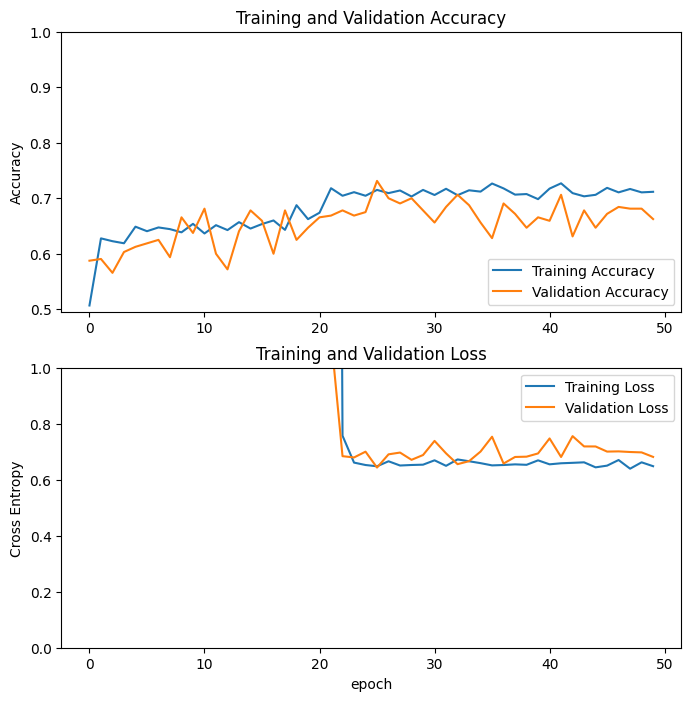

In [49]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
test_idx =10
class_labels =  ['Benign keratosis-like lesions', 'Melanocytic nevi', 'Melanoma']


print("Max index :", test_gen.__len__())
x,y = test_gen.__getitem__(10)
y_pred = model.predict(x)

Max index : 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


In [51]:
print("Y_pred : ",class_labels[np.argmax(y_pred[0])])
print("Y_true : ",class_labels[np.argmax(y[0])])

Y_pred :  Melanoma
Y_true :  Melanoma


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17072849..0.7959229].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14248072..0.7699578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08627688..0.7870381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18296807..0.7360426].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057922408..0.6180124].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1445183..0.5880186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

IndexError: index 10 is out of bounds for axis 0 with size 10

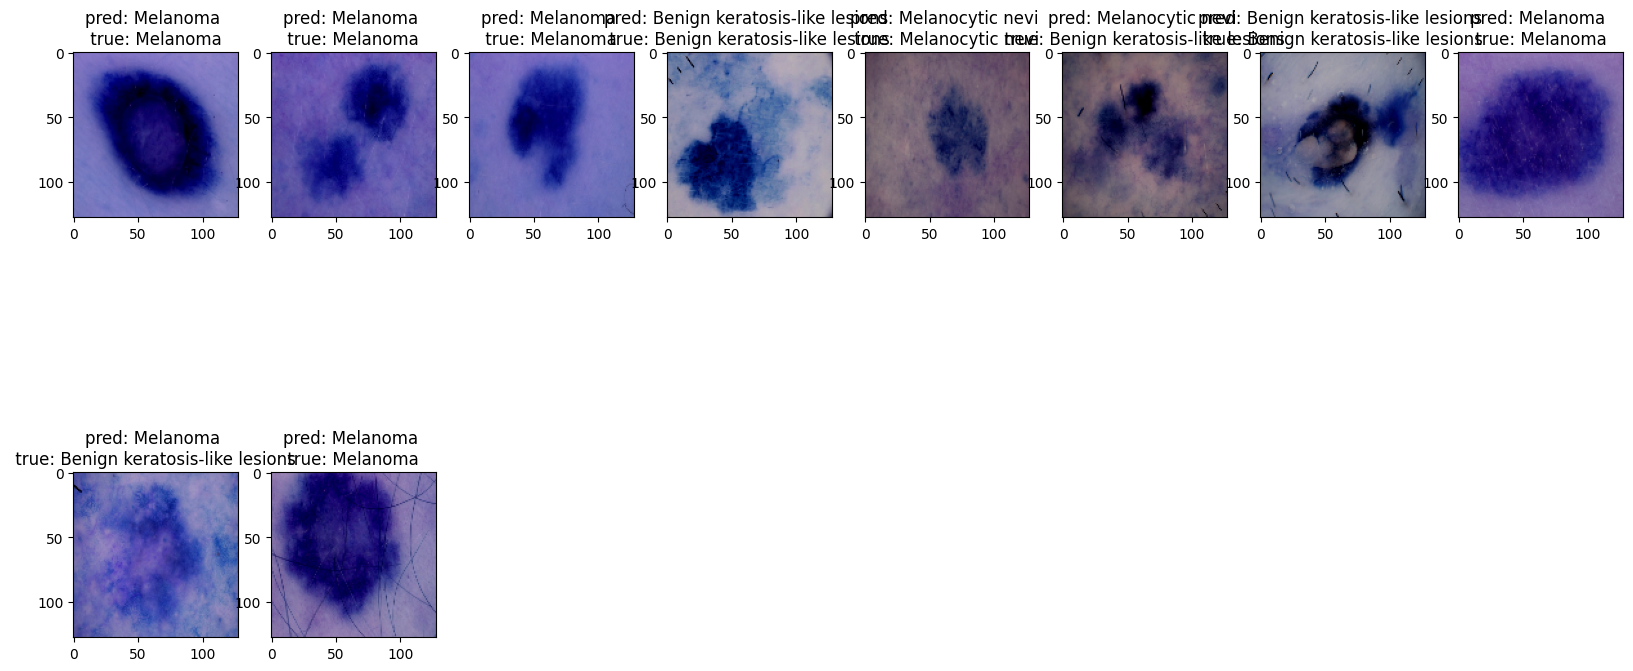

In [52]:
# plot sample
w = 20
h = 25
fig = plt.figure(figsize=(20, 10))
columns = 8  
rows = 2

count_id = 0
for i in range(1, columns*rows +1):
    img = x[count_id]
    cur_label = "pred: {} \n true: {} ".format(class_labels[np.argmax(y_pred[count_id])],class_labels[np.argmax(y[count_id])])

    ax1 = fig.add_subplot(rows, columns, i)
    ax1.set_title(cur_label)
    plt.imshow(img)
    count_id = count_id+1
plt.show()

In [ ]:
eval_loss, eval_acc = model.evaluate(test_gen)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7587 - loss: 0.7709on_epoch_end
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7592 - loss: 0.7710
Eval loss: 0.7731417417526245, Eval accuracy: 0.768750011920929


####  Save and Load Custom  Model

In [53]:
optimizer = tf.keras.optimizers.Adam()

In [54]:
new_model = MyModel(input_shape = input_shape,output_shape=output_shape)
new_model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])

In [55]:

eval_loss, eval_acc = new_model.evaluate(test_gen)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.3464 - loss: 1064.6375on_epoch_end
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.3473 - loss: 1064.6375
Eval loss: 1064.6373291015625, Eval accuracy: 0.35624998807907104


In [56]:
checkpoint_path = "training_1/custom_model.weights.h5"
new_model.load_weights(checkpoint_path)

/Users/tharhtet/.local/share/virtualenvs/tf_best_practices-7uf2K4aY/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [57]:

eval_loss, eval_acc = new_model.evaluate(test_gen)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.7230 - loss: 0.6569on_epoch_end
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.7235 - loss: 0.6562
Eval loss: 0.6493504047393799, Eval accuracy: 0.7281249761581421


In [58]:
label_encode = {'Melanocytic nevi' : [0,0,1] ,
                'Benign keratosis-like lesions':[0,1,0], 
                'Melanoma' : [1,0,0]}

In [74]:
import cv2
import numpy as np
def load_img(img_path):
    img = cv2.imread(img_path)
    image = tf.cast(img, tf.float32)
    image = tf.image.resize(image, [128, 128])
    image = (image / 255.0)
    img_reshape = np.array([image])
    return img_reshape


def pred_img(input_img,model):
    
    pred_ = model.predict(input_img)
    print(pred_)
    pred_label = [np.argmax(pred_)]
    return pred_label

In [85]:
img_path = os.getcwd()+"/skin_cancer/test/Melanoma/mel_99.jpg"
img_path = os.getcwd()+"/skin_cancer/test/Melanocytic nevi/nv_926.jpg"
#img_path = os.getcwd()+"/skin_cancer/test/Benign keratosis-like lesions/bkl_90.jpg"
img_path = os.getcwd()+"/skin_cancer/test/Benign keratosis-like lesions/bkl_902.jpg"

img = load_img(img_path)


In [86]:
class_list =   ['Melanoma', 'Benign keratosis-like lesions', 'Melanocytic nevi']
label =  pred_img(img, new_model)
print(class_list[label[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[0.7939882  0.75286293 0.09308998]]
Melanoma
